In [42]:
import re
import random
import pandas as pd
import hashlib

In [43]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [44]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,32.510680,2.955516,3.954203,11
Accounting,45.892830,2.699578,6.720309,17
pfSense,53.841881,4.486823,10.287798,12
Pandas,143.202845,47.734282,55.836874,3
Python + Oauth2.0,334.903268,14.561012,25.670374,23
Azure Files Documentation,379.771486,11.867859,25.039714,32
Terraform,949.811006,94.981101,221.025962,10
Azure DevOps Pipelines,1068.988532,106.898853,200.705459,10
Power BI,1282.306759,38.857781,61.478685,33
Azure Functions + PP365,1373.510198,98.107871,156.556234,14


# Histogram

sum of ages: ~48843.82


<Axes: >

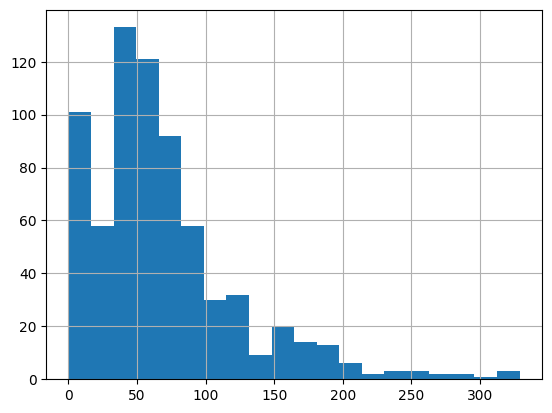

In [45]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~-48843.82


<Axes: >

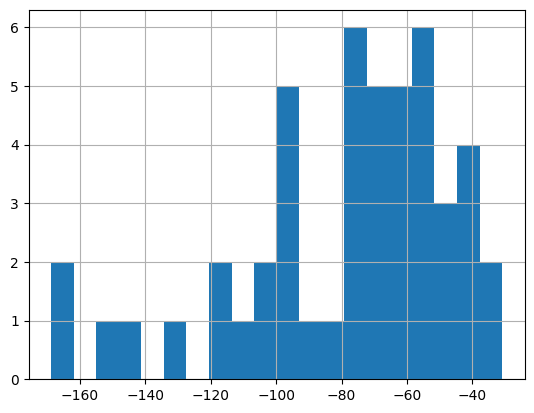

In [60]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [47]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [48]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [49]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [50]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 703
Total card age: 48843.82


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
175,Azure Developer Associate,Your company is developing a new web applicati...,466f3aae7fb7958ec8752dd6ace75557,-328.717251,-200.852060,328.717251,1606.816478,0.041490,8,0,0
176,Azure Developer Associate,"In the .NET SDK for Azure Cosmos DB for NoSQL,...",aeb02c24e551b80ec7573284fbb0fc82,-210.962844,-200.852060,328.717251,1606.816478,0.041490,8,3,0
177,Azure Developer Associate,You plan to implement a storage mechanism for ...,bd10ecb376186d364d36592c337f9cd9,-128.413764,-200.852060,328.717251,1606.816478,0.041490,8,6,0
194,Azure DevOps Pipelines,How do you run a pipeline on a self-hosted age...,0ac1ed550c9daa2946b919787429b4fc,-200.705459,-106.898853,200.705459,1068.988532,0.008752,10,0,0
195,Azure DevOps Pipelines,What does the 'variables' keyword do in a YAML...,add1c4206436b2b993c8a77191d15d0b,-103.090812,-106.898853,200.705459,1068.988532,0.008752,10,3,0
196,Azure DevOps Pipelines,"In Azure DevOps, what command is used to run a...",5843789a2ab93c36fae15bce2e58199b,-76.166557,-106.898853,200.705459,1068.988532,0.008752,10,6,0
197,Azure DevOps Pipelines,"In an Azure DevOps pipeline, which YAML syntax...",b13f80422b178a697f56625737302c5b,-64.073655,-106.898853,200.705459,1068.988532,0.008752,10,9,0
116,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-312.912352,-102.989690,312.912352,2471.752565,0.635397,24,0,0
117,C# Basics,An interface defines a contract that classes m...,e985b04311fcd2494bb5725cf33b2986,-173.868853,-102.989690,312.912352,2471.752565,0.635397,24,3,0
118,C# Basics,A constructor is a special method used to init...,cff83ac94df0a7e5f6ce64eb8d98220d,-112.444270,-102.989690,312.912352,2471.752565,0.635397,24,6,0


## Age Max

In [51]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [52]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [53]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [54]:
existing_cards.head(10)['age'].sum()

np.float64(-1711.3558168925558)

In [55]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
175,Azure Developer Associate,Your company is developing a new web applicati...,466f3aae7fb7958ec8752dd6ace75557,-328.717251,-200.852060,328.717251,1606.816478,0.041490,8,0,0
116,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-312.912352,-102.989690,312.912352,2471.752565,0.635397,24,0,0
6,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,-312.615047,-91.212027,312.615047,4834.237434,0.297289,53,0,0
142,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-311.422163,-94.239961,311.422163,1696.319291,0.396720,18,0,0
253,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,-286.799488,-91.212027,312.615047,4834.237434,0.297289,53,1,1
49,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,-281.225959,-86.383607,281.225959,4232.796750,0.107173,49,0,0
95,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,-279.274910,-93.909098,279.274910,2629.454737,0.217403,28,0,0
416,Azure Developer Associate,As the .NET SDK for Azure Cosmos DB for NoSQL ...,e7d9d1bada8400673bd3bdf99e9f3c40,-267.072951,-200.852060,328.717251,1606.816478,0.041490,8,1,1
340,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,-249.193461,-93.909098,279.274910,2629.454737,0.217403,28,1,1
237,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,-249.113728,-89.748463,249.113728,3410.441591,0.645460,38,0,0


In [56]:
existing_cards['age'].mean()

np.float64(-69.47911749948332)